# Нейросеть различающая котов и собак
https://www.youtube.com/watch?v=WmNmILXPj2Y
48 минута

In [1]:
!pip install torch torchvision numpy matplotlib opencv-python tqdm

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision as tv


import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os

from tqdm import tqdm

c:\Users\muzaf\anaconda3\envs\dog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()

        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2

        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
    def __len__(self):
        return  len(self.dir1_list) + len(self.dir2_list)

    def __getitem__(self,idx):
        
        if idx <= len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = img[:, :, ::-1]


        img = img.astype(np.float32)
        img = img/255

        img = cv2.resize(img, (50,50), interpolation = cv2.INTER_AREA)
        
        img.transpose((2, 0, 1))

        t_img = torch.from_numpy(img)

        t_class_id = torch.tensor(class_id)
      

        return {'img': t_img, 'label': t_class_id}
        

In [34]:
train_dogs_path = 'C:/Users/muzaf/Desktop/SUAI_AI/Cats and Dogs/training_set/dogs/'
train_cats_path = 'C:/Users/muzaf/Desktop/SUAI_AI/Cats and Dogs/training_set/cats/'

test_dogs_path = 'C:/Users/muzaf/Desktop/SUAI_AI/Cats and Dogs/test_set/dogs/'
test_cats_path = 'C:/Users/muzaf/Desktop/SUAI_AI/Cats and Dogs/test_set/cats/'

train_ds_catsdogs = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catsdogs = Dataset2class(test_dogs_path, test_cats_path)

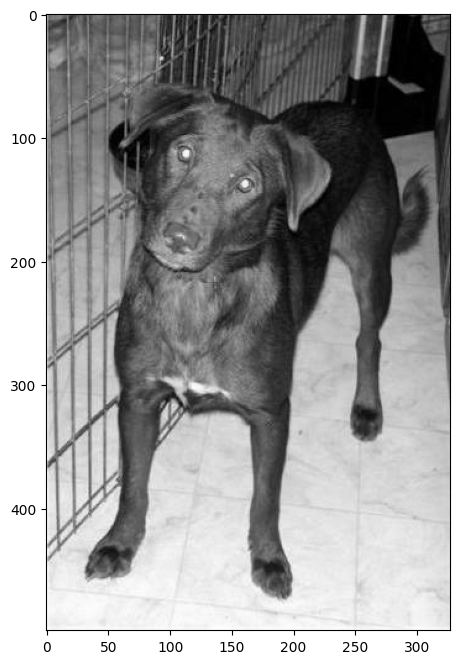

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(train_ds_catsdogs[1][0], cmap = 'gray')



In [37]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True, batch_size = batch_size, num_workers=1, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds_catsdogs, shuffle=True, batch_size = batch_size, num_workers=1, drop_last=False
)

NameError: name 'test_ds_catsdogs' is not defined